In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pyarrow as pa
from datetime import datetime, timedelta
from dateutil import rrule
import gcsfs
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
datasets = ["2023-05"]
bucket_name = "prediswiss-parquet-data"

In [4]:
fs_gcs = gcsfs.GCSFileSystem()
dataframes = []
for dataset in datasets:
    path = bucket_name + "/" + dataset + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    df = table.to_pandas()
    dataframes.append(df)
df = pd.concat(dataframes)

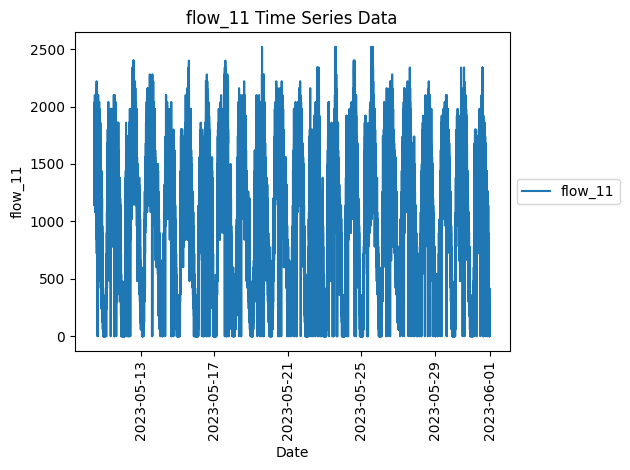

In [5]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = df[df['id'] == id].copy()

# Convert the 'publication_date' column to datetime
filtered_df[date] = pd.to_datetime(filtered_df[date])

# Convert the 'flow_11' column to numeric type
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')

filtered_df = filtered_df[[date, target]]

# Set 'publication_date' as the index
filtered_df.set_index(date, inplace=True)

# Resample the data to the desired frequency (e.g., minute 'T' or second 'S') and calculate the mean
flow_11_data = filtered_df.resample('T').mean().fillna(0)

# Split the data into training and testing sets
flow_11_data_train = flow_11_data.iloc[:24816]
flow_11_data_test = flow_11_data.iloc[24817:]

# Plot the time series data
plt.plot(flow_11_data.index, flow_11_data[target])
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{target} Time Series Data')
plt.xticks(rotation=90)
plt.legend([target], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [20]:
import statsmodels.api as sm

decompfreq = 6*24
ts_decomposed = sm.tsa.seasonal_decompose(flow_11_data, model='additive', extrapolate_trend=True, freq=decompfreq)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid

ts_decomposed.plot()
plt.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [ ]:
import pmdarima as pm

model = pm.auto_arima(ts_seasonal,start_p=1, d=1, start_q=1,
                            max_p=5, max_q=5,
                            m=5,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
model.fit(ts_seasonal)

pred = model.predict(n_periods=5000)

plt.plot(ts_test.index, ts_pred_decompose, label='decompose')
plt.plot(ts_test, label='actual')
plt.title('Decomposition')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-05-31 23:57:00+00:00     111.435853
2023-05-31 23:58:00+00:00     110.030087
2023-05-31 23:59:00+00:00     109.902402
2023-06-01 00:00:00+00:00     109.799041
2023-06-01 00:01:00+00:00     109.696142
                                ...     
2023-06-21 19:52:00+00:00   -2976.067731
2023-06-21 19:53:00+00:00   -2976.170620
2023-06-21 19:54:00+00:00   -2976.273510
2023-06-21 19:55:00+00:00   -2976.376400
2023-06-21 19:56:00+00:00   -2976.479289
Freq: T, Name: predicted_mean, Length: 30000, dtype: float64


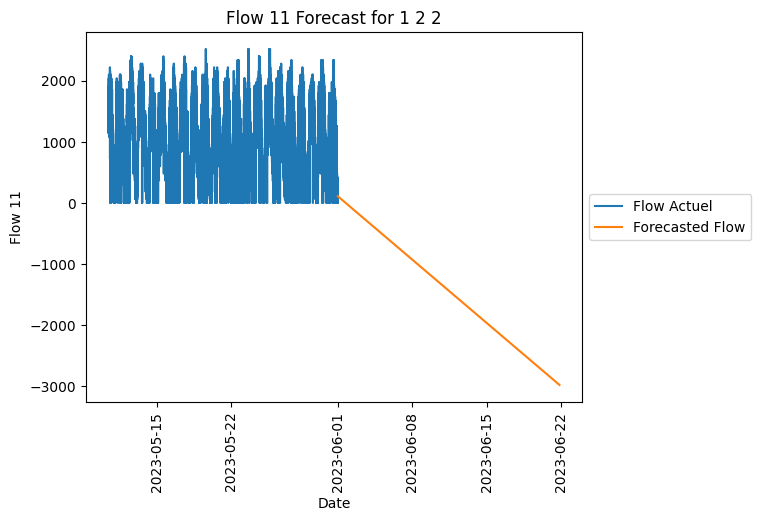

<Figure size 1200x600 with 0 Axes>

In [63]:
model = ARIMA(flow_11_data, order=(1, 2, 2))
# Fit the model to the data
model_fit = model.fit()

# Forecast future values
forecast_values = model_fit.forecast(30000)

print(forecast_values)

# Plot the original data and the forecasted values
plt.plot(flow_11_data, label='Original Data')
plt.plot(forecast_values, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Flow 11')
plt.title('Flow 11 Forecast for ' + " ".join(str(element) for element in (1,2,2)))
# Adjust the legend orientation and position
plt.legend(['Flow Actuel', 'Forecasted Flow'], loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis tick labels for vertical orientation
plt.xticks(rotation=90)

# Adjust the figure size to extend the width
plt.figure(figsize=(12, 6))
plt.show()